## Load Data

We load the initial training data. Skip this entire section if the train model is available under `analysis_best_model/best_model_bayesian_optimization.h5` and jump down to <font style="font-size:13pt; font-weight: bold">Load The Model<font>

### Calculating Fingerprints

In [1]:
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem

supplier = Chem.SDMolSupplier('data/cas_4337.sdf')
infos = [{} for mol in supplier]
fingerprints = np.array([AllChem.GetMorganFingerprintAsBitVect(supplier[i], 3, nBits=2048, bitInfo=infos[i]) 
                         for i in range(len(supplier))])

### Splitting Dataset

into train and validation sets

In [2]:
valid_ids = [6,   10,   29,   32,   42,   58,   72,   83,   98,  100,  128, 
        145,  148,  168,  171,  205,  208,  237,  244,  285,  290,  291,
         300,  312,  332,  334,  335,  347,  356,  369,  371,  377,  407,
         424,  456,  458,  470,  472,  486,  514,  515,  528,  557,  563,
         599,  610,  616,  628,  640,  701,  704,  722,  764,  794,  818,
         821,  840,  850,  856,  859,  874,  878,  882,  898,  901,  925,
         936,  945,  957,  974,  977, 1013, 1019, 1030, 1038, 1047, 1049,
        1072, 1073, 1100, 1159, 1168, 1187, 1190, 1194, 1201, 1202, 1233,
        1247, 1258, 1264, 1273, 1283, 1288, 1300, 1302, 1319, 1339, 1349,
        1402, 1413, 1416, 1422, 1426, 1435, 1454, 1465, 1483, 1502, 1513,
        1515, 1520, 1548, 1576, 1604, 1606, 1621, 1650, 1695, 1696, 1711,
        1714, 1716, 1725, 1743, 1746, 1752, 1780, 1788, 1794, 1799, 1813,
        1826, 1866, 1886, 1901, 1903, 1921, 1929, 1940, 1969, 1970, 1997,
        1998, 2008, 2010, 2011, 2018, 2023, 2046, 2060, 2064, 2080, 2081,
        2131, 2171, 2182, 2203, 2212, 2224, 2231, 2241, 2246, 2283, 2294,
        2295, 2297, 2327, 2329, 2331, 2349, 2357, 2360, 2365, 2397, 2413,
        2417, 2418, 2421, 2448, 2467, 2510, 2516, 2528, 2533, 2549, 2562,
        2601, 2604, 2606, 2609, 2611, 2632, 2644, 2653, 2677, 2682, 2685,
        2692, 2703, 2708, 2714, 2719, 2726, 2732, 2759, 2761, 2776, 2780,
        2817, 2818, 2829, 2837, 2857, 2858, 2884, 2899, 2902, 2905, 2911,
        2939, 2975, 2977, 2986, 3007, 3009, 3018, 3024, 3038, 3066, 3087,
        3098, 3107, 3117, 3122, 3139, 3157, 3161, 3164, 3217, 3223, 3233,
        3263, 3265, 3271, 3290, 3295, 3307, 3313, 3317, 3321, 3382, 3384,
        3388, 3400, 3409, 3412, 3419, 3423, 3449, 3470, 3487, 3488, 3503,
        3509, 3511, 3539, 3562, 3626, 3637, 3654, 3662, 3663, 3668, 3671,
        3688, 3689, 3695, 3710, 3726, 3743, 3744, 3782, 3791, 3794, 3808,
        3809, 3841, 3849, 3874, 3910, 3912, 3925, 3945, 3950, 3958, 3959,
        3962, 3964, 3967, 3978, 3993, 4009, 4010, 4055, 4057, 4085, 4089,
        4096, 4099, 4107, 4112, 4129, 4135, 4151, 4155, 4196, 4209, 4216,
        4234, 4236, 4251, 4267, 4283, 4317, 4326, 4335
]

In [3]:
X_train = []
X_valid = []
for i in range(len(fingerprints)):
    if i in valid_ids:
        X_valid.append(fingerprints[i])
    else:
        X_train.append(fingerprints[i])
X_train = np.array(X_train)
X_valid = np.array(X_valid)

Collecting the lables from the supplier

In [4]:
y_train, y_valid, i = [], [], 0
for mol in supplier:
    if mol.GetProp("Ames test categorisation") == "mutagen":
        if i in valid_ids:
            y_valid.append(1)
        else:
            y_train.append(1)
    else:
        if i in valid_ids:
            y_valid.append(0)
        else:
            y_train.append(0)
    i+=1
    
y_train = np.array(y_train)
y_valid = np.array(y_valid)

## Optimizing Model's Architecture

Using the Bayesian Inference

In [79]:
from keras import backend as k
from keras.models import Sequential
from keras.layers import Activation, Dropout
from keras.layers.core import Dense
from keras.optimizers import SGD, Adam

from sklearn.metrics import roc_auc_score

import time

from bayes_opt import BayesianOptimization

Here we set the our search space as well as the substitution function

In [115]:
param_reference = {'init': ['lecun_uniform', 'he_uniform'],
             'activation': ['relu', 'sigmoid', 'selu'],
              'optimizer': [SGD, Adam]
                  }

search_space = {'units': (5, 2048), # discrete
                'activation': (0, 2), # categorical
                'optimizer': (0, 2), # categorical
                'lr': (.00001, .2), # continuous
                'n_layers': (2, 15), # discrete
                'epochs': (5, 30), # discrete
                'batch_size': (1, 200), # discrete
                'momentum': (0.001, 0.5), # continuous
                'init': (0, 1), # categorical
                'dropout_rate': (0.0001, 0.9) # continuous
               }



input_dim = X_valid.shape[1]
def train_evaluate_and_auc(units, activation, optimizer, lr, n_layers, epochs, batch_size, momentum, init, dropout_rate):
    # handle categorical
    activation = param_reference['activation'][int(round(activation))]
    optimizer = param_reference['optimizer'][int(round(optimizer))]
    init = param_reference['init'][int(round(init))]
    # handle discrete
    units = int(round(units))
    n_layers = int(round(n_layers))
    epochs = int(round(epochs))
    batch_size = int(round(batch_size))
    
    # build classifier with corresponding hyperparameters
    keras.backend.clear_session()
    classifier = Sequential()
    classifier.add(
        Dense(units=units, input_dim=input_dim, activation=activation, kernel_initializer=init) # input layer
    )
    # Create an arbitrary number of Hidden Layers
    for n in range(n_layers):
        classifier.add(Dense(units=units, activation=activation))
        classifier.add(Dropout(dropout_rate))
    classifier.add(Dense(units=1, activation='sigmoid'))     # Output Layer
    if optimizer == SGD:
        optimizer = SGD(learning_rate=lr, momentum=momentum)
    else:
        optimizer = Adam(learning_rate=lr)
    classifier.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    # FIXME: adjust epochs and batch size
    classifier.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=0)
    return roc_auc_score(y_valid, classifier.predict(X_valid))

run and time the Bayesian optimization process.

In [57]:
start_time = time.ctime()
optimization = BayesianOptimization(f=train_evaluate_and_auc, pbounds=search_space, random_state=0)
optimization.maximize(init_points=10, n_iter=30)
print("Bayesian Optimization took {}".format(time.ctime() - start_time))

print(optimization.max)
# for i, res in enumerate(optimization.res):
#     print("Iteration {}: \n\t{}".format(i, res))

|   iter    |  target   | activa... | batch_... | dropou... |  epochs   |   init    |    lr     | momentum  | n_layers  | optimizer |   units   |
-------------------------------------------------------------------------------------------------------------------------------------------------
|  1        |  0.7511   |  0.5488   |  38.61    |  0.5822   |  15.45    |  0.4237   |  0.006813 |  0.375    |  4.675    |  0.9637   |  22.25    |
|  2        |  0.7748   |  0.7917   |  31.16    |  0.5544   |  19.26    |  0.07104  |  0.001784 |  0.2081   |  4.498    |  0.7782   |  44.15    |
|  3        |  0.7762   |  0.9786   |  41.97    |  0.4692   |  17.81    |  0.1183   |  0.006759 |  0.2573   |  4.834    |  0.5218   |  23.66    |
|  4        |  0.8575   |  0.2646   |  40.97    |  0.4649   |  15.68    |  0.01879  |  0.006559 |  0.4448   |  3.851    |  0.9437   |  35.68    |
|  5        |  0.6349   |  0.3595   |  27.48    |  0.6581   |  10.6     |  0.6668   |  0.007036 |  0.2842   |  2.387    |  0

### Set of best hyperparameters

Because the optimization treats all hyperparameters in a continuous way, let's convert them into a interpretable way.

In [100]:
import re
def convert_to_interpretable_dict(optimization_max):
    """ Returns an interpretable dictionary given the a single dictionary from the Bayesian Optimization object above
    """
    interpretable_dict = {}
    interpretable_dict['AUC'] = optimization_max['target']
    interpretable_dict['activation'] = param_reference['activation'][int(round(optimization_max['params']['activation']))] # categorical
    interpretable_dict['batch_size'] = int(round(optimization_max['params']['batch_size']))
    interpretable_dict['dropout_rate'] = optimization_max['params']['dropout_rate']
    interpretable_dict['epochs'] = int(round(optimization_max['params']['epochs']))
    interpretable_dict['init'] = param_reference['init'][int(round(optimization_max['params']['init']))] # categorical
    interpretable_dict['lr'] = optimization_max['params']['lr']
    interpretable_dict['momentum'] = optimization_max['params']['momentum']
    interpretable_dict['n_layers'] = int(round(optimization_max['params']['n_layers']))
    interpretable_dict['optimizer'] = re.findall("[A-Z|a-z]+\'", str(param_reference['optimizer'][int(round(optimization_max['params']['optimizer']))]))[0][:-1] # categorical
    interpretable_dict['units'] = int(round(optimization_max['params']['units']))
    return interpretable_dict

Apply a pretty output 

In [103]:
import pandas as pd

interpretable_dict = convert_to_interpretable_dict(optimization.max)
pd.DataFrame.from_dict(interpretable_dict, orient='index', columns=['Best']).T.style.set_caption("Results of Bayesian Optimization: best set of hyperparameters")

,AUC,activation,batch_size,dropout_rate,epochs,init,lr,momentum,n_layers,optimizer,units
Best,0.877166,relu,10,0.1,10,lecun_uniform,0.01,0.6,2,Adam,50


## Running Model on Test set

Make sure to specify the `input_shape` instead of usual `input_dim`. <font style="font-family: georgia; font-weight: normal; font-size: 16pt">Keras</font> has updated there Dense constructor.

In [99]:
from keras import backend as k
# build model with corresponding hyperparameters
k.clear_session()
model = Sequential()
model.add(
    Dense(units=50, input_shape=X_valid[0].shape, activation='relu', kernel_initializer='lecun_uniform') # input layer
)
# Create an arbitrary number of Hidden Layers
for n in range(2):
    model.add(Dense(units=50, activation='relu'))
    model.add(Dropout(0.1))
model.add(Dense(units=1, activation='sigmoid'))     # Output Layer
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.01), metrics=['accuracy'])
# FIXME: adjust epochs and batch size
model.fit(X_train, y_train, batch_size=10, epochs=10, verbose=0)

### Loading Test set

Run the following 2 cells to load the test set, and then will obtain them in `X_test`, `y_test`

In [187]:
import csv

smiles, y_test = [], []
with open('data/test.csv') as f:
    csv_reader = csv.reader(f, delimiter=',')
    for row in csv_reader:
        if row[1] != 'smiles':
            # read smiles from the 2nd column
            smiles.append(row[1])
            # read labels from the 3rd column
            y_test.append(row[2])

In [188]:
info_dicts, X_test, supplier_test = [], [], []
for smile in smiles:
    m = Chem.MolFromSmiles(smile)
    supplier_test.append(m)
    info = {}
    bit_vector = AllChem.GetMorganFingerprintAsBitVect(m, 3, nBits=2048, bitInfo=info)
    X_test.append(bit_vector)
    info_dicts.append(info)
    
X_test = np.array(X_test)
y_test = np.array(y_test, dtype=np.int8)

### Plotting test set ROC

In [82]:
def plot_roc(fpr, tpr, roc_auc):
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

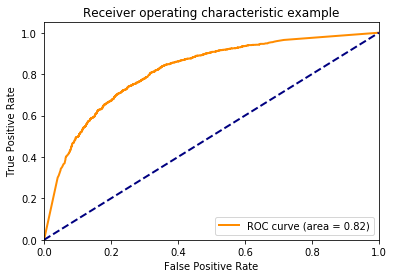

In [83]:
%matplotlib inline
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

y_test_pred = model.predict(X_test)
auc = roc_auc_score(y_test, y_test_pred)
fpr, tpr, _ = roc_curve(y_test, y_test_pred)
plot_roc(fpr, tpr, auc)

### Saving the model

For later uses. In order not to overwrite my original model, I generate a random number that gets appended to the end of the model's name.

In [162]:
import random
model.save("analysis_best_model/best_model_bayesian_optimization_{}.h5".format(random.randint(1,9999)))

### Load the Model

For later uses

In [7]:
from keras.models import load_model
model = load_model('analysis_best_model/best_model_bayesian_optimization.h5')

Using TensorFlow backend.
/Users/kareem/miniconda3/envs/molecules_and_ml/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/kareem/miniconda3/envs/molecules_and_ml/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/kareem/miniconda3/envs/molecules_and_ml/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16",

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



To see model evaluation, look at the cells above.
This was just a sanity check that I'd like to make, to make sure not to load the wrong model. So in order to check that this model has the same weights as the one reported in my last report, I had to load it and then reevaluate it on the test set, and see if I get the same AUC score.

# Integrated Gradients

In the following we provide an implementation for the integrated gradients. Steps of the implementation are:
1. Consider a baseline such that the output $F(x^\prime)=\bigcirc$ where $x^\prime$ is the baseline and $\bigcirc$ is the default class. In our case, we uses the zero-vector that actually signals the absence of any fingerprints.
2. Now, interpolate a series of images, increasing in intensity ($\alpha$), between the baseline image and the original (target) image. In another word, define a function $\gamma(\alpha) \rightarrow [0, 1]$ such that $F(x_i)=1$ and $F(x_i^\prime)=0$. In our implementation, this is defined as a *lambda* function in python.
3. Gradients of the output with respect to these series of interpolated images, when calculated gives us the following

$$grad = \left[ \begin{array}{rrrrrr}
[& 0.0073032 & g_2^1 & ... & g_m^1 &] \\
[& g_1^2 & g_2^2 & \cdots & g_m^2 &] \\
[& \vdots & \vdots & \cdots & \vdots  \\
[& g_1^s & g_2^s & \cdots & g_m^s &] \\
\end{array}\right.
\left. \begin{array}{rr}
\text{when} & \alpha=\frac{1}{s} \\
 & \alpha=\frac{2}{s} \\
 & \vdots \\
 & \alpha=1 \\
\end{array}\right] \
$$

> *FIXME: write out the rest of the steps*

4. Our region of interest lies where the slope of the score vs intensity graph doesn't remain stagnant. We call these gradients - *interesting gradients*. I.e. we calculate the gradient for every potentially possible input that lies between the original input $x_i$ and the baseline $x_i^\prime$. See `t_gradients` in the implementation.

5. The integration of these series of gradients give us the Integrated gradients of the image. The result of this step is a vector that has the same dimension as the input. And each element (attribution) in this vector corresponds to one features in the input sample. That's of course is equivalent to taking the average of the interesting gradients.

6. We repeat these steps for every sample in our dataset

#### Author Implementation

In the following cell, I provide the implementation of the integrated gradients that the author provides (<u>not working</u>).

In [ ]:
import tensorflow as tf
from keras import backend as keras
import numpy as np

def integrated_gradients(inp, baseline, label, steps=50):
    t_input = input_tensor() # input tensor
    t_prediction = prediciton_tensor(label) # output tensor
    t_gradients = tf.gradients(t_prediction, t_input)[0] # gradients
    path_inputs = [baseline + (i/steps)*(inp-baseline) for i in range(steps)]
    grads = run_network(t_gradients, path_inputs)
    return (inp-baseline)*np.average(grads, axis=0) # integration

#### My Implementation (not working)

In the following, I provide my own implementation of the integrated gradients according to my understanding of the math formula in the paper(<u>not working</u>).

In [182]:
from keras import backend as k
import numpy as np

def integrated_gradients(inp, baseline=None, steps=50):
    """My own implementation of the integrated gradients. I've made this over the formula under section "Computing
    Integrated Gradients". Returns the a vector of attributions where each element in the vector corresponds to one
    value in the input. The attributions vector has the same shape as the input.
    @Params
    ------
    inp:    The target input. i.e. One input sample (numpy.array) (e.g. one image, one molecule).
    baseline:      (Optional) The baseline vector - if not provided, the zero-vector is calcualted.
    steps:         (Optional), number of steps for integral estimation. = 50 by default

    @Returns
    -------
    Attribution vector
    """
    gradients = []
    inp = inp.reshape(1, -1) # original input
    if baseline is None:
        baseline = np.zeros(inp.shape)
    # gamma calculates the path function for a given alpha
    gamma = lambda alpha: baseline + float(alpha)/steps*(inp - baseline)

    for alpha in range(steps+1):
        input_tensor = gamma(alpha).reshape(1, -1) # path input tensor
        output_tensor = model.predict(input_tensor) # output tensor
        gradient = k.gradients(model.output, model.input)[0]
        # run the session
        sess = k.get_session()
        results = sess.run(gradient, feed_dict={model.output: output_tensor, model.input: input_tensor})[0]
        gradients.append(results)

    gradients = np.array(gradients)
    return (inp-baseline) * np.average(gradients, axis=0)

To prove the correctness of the method try

$$F(x)-F(x^\prime)=\sum_{i=1}^m a_i$$

Where $a_i$ the $i^{th}$ element in the attribution vector $a = [a_1, a_2, ..., a_m]$

In [183]:
attributions = integrated_gradients(X_test[0])
np.sum(attributions)

-0.11709215719019994

In [184]:
model.predict(X_test[0].reshape(1, -1)) - model.predict(baseline.reshape(1, -1))

array([[-0.11717556]], dtype=float32)

Prove that gamma is working $\gamma(x):R^d \rightarrow [0, 1]$  such that

$$\begin{align}
\gamma(x_i) = 1 &\qquad \text{when} &  x_i &=x \\
\gamma(x_i) = 0 &\qquad \text{when} & x_i &= baseline \\
\end{align}$$

In [141]:
gamma = lambda alpha: baseline + float(alpha)/steps*(inp - baseline)
inp = X_test[478]
baseline = np.zeros(shape=inp.shape)
steps = 50

print("Is gamma equal to input when alpha=1?")
print(gamma(1) == inp)
print("Is gamma equal to baseline when alpha=0?")
print(gamma(0) == baseline)
print("Is gamma equal to baseline when alpha=1?")
print(gamma(1) == baseline)
print("Is gamma equal to input when alpha=0?")
print(gamma(0) == input)

Is gamma equal to input when alpha=1?
[ True  True  True ...  True  True False]
Is gamma equal to baseline when alpha=0?
[ True  True  True ...  True  True  True]
Is gamma equal to baseline when alpha=1?
[ True  True  True ...  True  True False]
Is gamma equal to input when alpha=0?
[False False False ... False False False]


In [ ]:
attributions = np.array([integrated_gradients(sample) for sample in X_test])
attributions.shape

## Using GitHub Implemention

Just for the sake of visualization, I'm using this package. However, once my implementation is successfully working, I will change it.
**Update 09.10.2019**: my implementation works now, so you can skip the following cells.

In [125]:
from modules.IntegratedGradients import integrated_gradients as IG
ig = IG(model)

Evaluated output channel (0-based index): All
Building gradient functions
Progress: 100.0%
Done.


/Users/kareem/miniconda3/envs/molecules_and_ml/lib/python3.6/site-packages/keras/engine/sequential.py:111: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


(2048,)

In [163]:
attributions = np.array([ig.explain(inp, num_steps=500) for inp in X_test])

Testing the correctness of the implementation

In [164]:
np.sum(attributions[1])

-0.006888923740014433

In [165]:
model.predict(X_test[1].reshape(1, -1)) - model.predict(baseline.reshape(1, -1))

[[-0.00696187]]


Close enough too, and therefore equivalently correct 👍😉!

### Trying out another baseline

We want to understand the importance of choosing a baseline when using the integrated gradients. In that regard, we'll try out a new gradient where the most occuring fingerprints are. 

In [353]:
info_dicts = np.array(info_dicts)

In [344]:
np.argmax(np.sum(X_test, axis=1))

1803

Molecule apparently has many fingerprints. Let's see how it looks like.

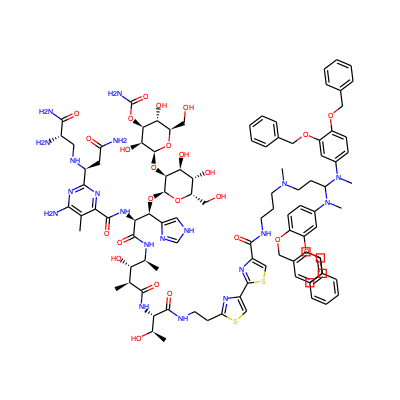

In [345]:
mol_high_fps = supplier_test[1803]
Draw.MolToImage(mol_high_fps, size=(400, 400))

In [347]:
len(info_dicts[1803])

234

so this molecule here has $234$ different fingerprints. We can check by seeing the length of dictionaries inside `info_dicts`

In [352]:
mylen = np.vectorize(len)
np.argmax(mylen(np.array(info_dicts)))

1803

According to the size of the dictionary, this is indeed the largest dictionary.

Following are all the indices of those molecules that have present fingerprints at the beginning.

In [365]:
indices_fp_at_0 = []
for i in range(len(X_test)):
    if X_test[i][0] == 1:
        indices_fp_at_0.append(i)
np.array(indices_fp_at_0)

array([ 163,  184,  454,  485,  489,  695,  956, 1038, 1247, 1281, 1282,
       1302, 1352, 1541, 1577, 1846, 1988, 2159, 2367, 2741, 2755, 2773,
       2811, 2959, 3055, 3258])

In [369]:
info_dicts[163]

{0: ((37, 3),),
 30: ((5, 3),),
 34: ((11, 2),),
 45: ((35, 2),),
 121: ((28, 2),),
 122: ((2, 3),),
 140: ((32, 2),),
 147: ((15, 3),),
 202: ((11, 1), (15, 1)),
 249: ((1, 2),),
 285: ((6, 3),),
 298: ((6, 2),),
 314: ((9, 1), (19, 1)),
 352: ((6, 1),),
 361: ((14, 1),),
 495: ((2, 2),),
 505: ((27, 2),),
 522: ((39, 3),),
 550: ((37, 2),),
 560: ((31, 1),),
 587: ((8, 2),),
 637: ((13, 3),),
 650: ((9, 0), (19, 0), (25, 0)),
 656: ((39, 0),),
 679: ((26, 1),),
 687: ((39, 2),),
 694: ((21, 2),),
 695: ((1, 0), (28, 0)),
 722: ((37, 1),),
 756: ((8, 3),),
 773: ((11, 3),),
 807: ((12, 0), (16, 0), (22, 0), (23, 0), (36, 0)),
 841: ((0, 1),),
 842: ((26, 2),),
 875: ((14, 3),),
 881: ((32, 0),),
 882: ((28, 3),),
 897: ((17, 3),),
 926: ((20, 0), (26, 0), (30, 0)),
 940: ((20, 1),),
 973: ((18, 2),),
 974: ((35, 3),),
 984: ((5, 2),),
 1017: ((24, 1),),
 1019: ((27, 0), (29, 0), (31, 0), (35, 0), (37, 0), (31, 3)),
 1028: ((30, 2),),
 1039: ((4, 2),),
 1041: ((20, 3),),
 1057: ((0, 0)

In [370]:
info_dicts[184]

{0: ((3, 3),),
 80: ((5, 0),),
 216: ((7, 3), (20, 3)),
 221: ((13, 3), (14, 3)),
 226: ((4, 3),),
 235: ((2, 2), (22, 2)),
 310: ((3, 2), (21, 2)),
 352: ((13, 1), (14, 1)),
 371: ((9, 2), (18, 2)),
 460: ((8, 2), (19, 2)),
 471: ((12, 3), (15, 3)),
 673: ((7, 2), (20, 2)),
 690: ((5, 2),),
 757: ((8, 3), (19, 3)),
 824: ((1, 3),),
 880: ((6, 2),),
 882: ((5, 3),),
 935: ((6, 0),),
 984: ((12, 2), (15, 2)),
 1019: ((7, 0), (20, 0)),
 1027: ((8, 1), (19, 1)),
 1057: ((0, 0),),
 1088: ((10, 1), (11, 1), (16, 1), (17, 1)),
 1094: ((6, 1),),
 1199: ((10, 2), (11, 2), (16, 2), (17, 2)),
 1268: ((2, 3),),
 1279: ((10, 3), (17, 3)),
 1297: ((13, 2), (14, 2)),
 1321: ((11, 3), (16, 3)),
 1380: ((1, 0), (4, 0), (8, 0), (13, 0), (14, 0), (19, 0)),
 1593: ((9, 3), (18, 3)),
 1683: ((4, 2),),
 1722: ((0, 1),),
 1750: ((2, 1), (3, 1), (9, 1), (12, 1), (15, 1), (18, 1), (21, 1), (22, 1)),
 1754: ((4, 1),),
 1765: ((5, 1),),
 1823: ((1, 1),),
 1837: ((6, 3),),
 1873: ((2, 0),
  (3, 0),
  (9, 0),
  (

That's the fingerprint set at position one in the bit vector for molecule $163$.

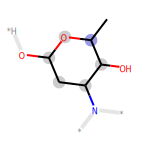

In [376]:
display(SVG(Draw.DrawMorganBit(supplier_test[163], 0, info_dicts[163])))

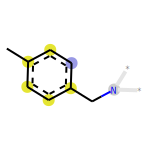

In [377]:
display(SVG(Draw.DrawMorganBit(supplier_test[184], 0, info_dicts[184])))

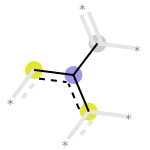

In [380]:
display(SVG(Draw.DrawMorganBit(supplier_test[163], 352, info_dicts[163])))

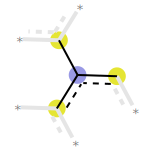

In [381]:
display(SVG(Draw.DrawMorganBit(supplier_test[184], 352, info_dicts[184])))

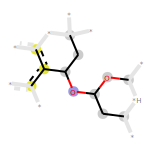

In [382]:
display(SVG(Draw.DrawMorganBit(supplier_test[163], 882, info_dicts[163])))

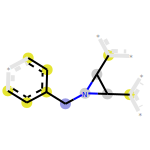

In [383]:
display(SVG(Draw.DrawMorganBit(supplier_test[184], 882, info_dicts[184])))

One more example

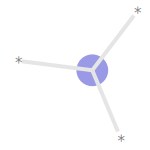

In [384]:
display(SVG(Draw.DrawMorganBit(supplier_test[163], 1019, info_dicts[163])))

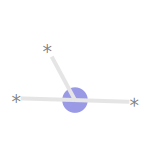

In [385]:
display(SVG(Draw.DrawMorganBit(supplier_test[184], 1019, info_dicts[184])))

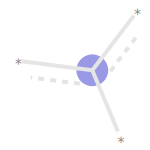

In [386]:
display(SVG(Draw.DrawMorganBit(supplier_test[163], 1380, info_dicts[163])))

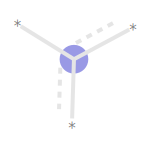

In [387]:
display(SVG(Draw.DrawMorganBit(supplier_test[184], 1380, info_dicts[184])))

Here we can see that the all bits in one column refer to the same fingerprint, so in order to find the most common figerprint, we just have to find the column with the highest $1$s.

In [409]:
np.argmax(np.sum(X_test, axis=0))

1380

In [415]:
column_with_high_fps = X_test[:, 1380]
column_with_high_fps

array([1, 1, 1, ..., 1, 1, 0])

And $1380$th column is the most frequent fingerprint

In [416]:
np.count_nonzero(column_with_high_fps)

2542

This fingerprint is present in $2542$ molecules of the entire dataset. To make a quick sanity chekc let's find out whether there are other columns that have as many ones.

In [423]:
import random

myCounts = []
for i in range(100):
    random_index = random.randint(0, 2048)
    myCounts.append(np.count_nonzero(X_test[:, random_index]))
np.array(myCounts)

array([  57,   26,   50,   23,   32,   27,   34,   32,   35,  216,   54,
         66,   24,   40,   31,   43,   19,   85,   22,   36,   39,   53,
         57,   50,   29,   25,   35,   42,   24,   99,   27,   33,   39,
         64,   55,   27,   53,   20,   85,  109,   24,   41,   26,   71,
         43,   33,   25,   38,   30,   53,  213,   11,   51,   48,   29,
        145,   23,   62,   26,   30,   34,   26,   18,   76,   37,   12,
         33,   29,   22,   87,   29,   81,  205,   30,   22,   71,   35,
         45,   30,   83,   45,  392,   46,  119,   14,  453,   40,   71,
        285,   35,   51,   43,   30,   41,   22,   26,   24,   19, 2013,
         24])

So it looks like, we've successfully got the column with highest number of ones.

While thinking about this issue it occurred to me that it's doesn't make any difference what column has the highest fingerprints because that's not what we're looking. What we want to to construct is a baseline that has the most frequent number in the column.

In [ ]:
a = np.array([1,2,3,1,2,1,1,1,3,2,2,1])
counts = np.bincount(a)
print(np.argmax(counts))

## Visualizing the Attribution

apparently what needs to be done here is to replace the `DataStructs.TanimotoSimilarity` with the my own attribution score that I get, in order to visualize the attribution correctly. However, I still don't know what type of function that is.

Additionally, I should provide the zero-vector for the reference fingerprints.

In the following I'd like to demonstrate the functionality of similarity. So I'm going to draw one molecule and then another one, and then plot the similarity between the two. These are two random molecules that don't belong to the dataset I have. It's just for demonstration purposes.

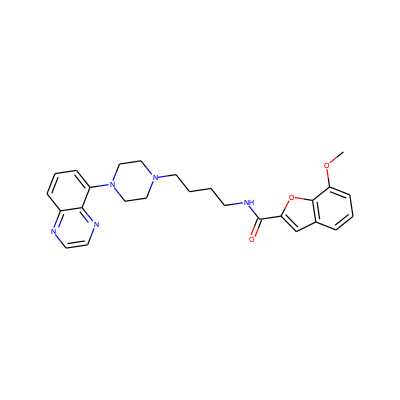

In [267]:
Draw.MolToImage(mol, size=(400, 400))

Pay attention that the following cell overwrites `refmol` which isn't desired, because I always use the name `refmol` for the target molecule.

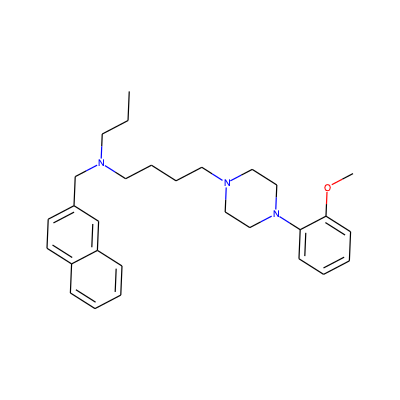

In [270]:
refmol = Chem.MolFromSmiles('CCCN(CCCCN1CCN(c2ccccc2OC)CC1)Cc1ccc2ccccc2c1')
Draw.MolToImage(refmol, size=(400, 400))

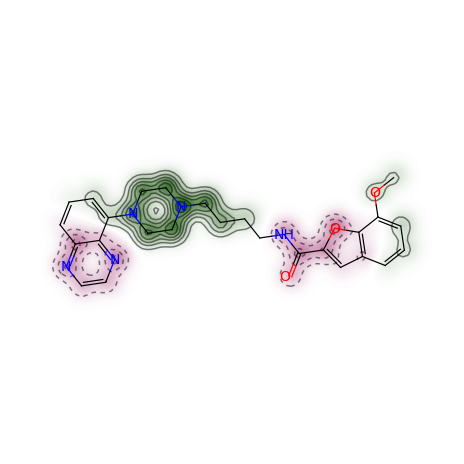

In [271]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import SimilarityMaps
from rdkit import DataStructs

mol = Chem.MolFromSmiles('COc1cccc2cc(C(=O)NCCCCN3CCN(c4cccc5nccnc54)CC3)oc21', )
refmol = Chem.MolFromSmiles('CCCN(CCCCN1CCN(c2ccccc2OC)CC1)Cc1ccc2ccccc2c1')

# fig, maxweight = SimilarityMaps.GetSimilarityMapForFingerprint(refmol, mol, lambda m, idx: SimilarityMaps.GetMorganFingerprint(m, atomId=idx, radius=3, fpType='count', nBits=2048),
#                                                                metric=DataStructs.TanimotoSimilarity)
fig, maxweight = SimilarityMaps.GetSimilarityMapForFingerprint(refmol, mol, lambda m, idx: SimilarityMaps.GetMorganFingerprint(m, atomId=idx, radius=3, fpType='count', nBits=2048),
                                                               metric=DataStructs.TanimotoSimilarity)

I just noticed one tiny problem while I plotting, which is that the second argument in the previous function should be the reference molecule.

No we'll try to do the same for our first molecule and its fingerprints. So let's view the info dictionary for the first molecule in the test set.

In [197]:
info_dicts[0]

{290: ((29, 3), (18, 3)),
 314: ((0, 1), (9, 1), (20, 1), (28, 1), (38, 1), (46, 1)),
 331: ((11, 3), (36, 3)),
 504: ((1, 3), (37, 3)),
 525: ((8, 1), (19, 1), (27, 1), (37, 1), (45, 1), (1, 1)),
 650: ((0, 0), (9, 0), (20, 0), (28, 0), (38, 0), (46, 0)),
 747: ((14, 3), (33, 3)),
 764: ((16, 2), (31, 2)),
 776: ((15, 2), (32, 2)),
 826: ((10, 3), (47, 3)),
 909: ((6, 3), (3, 3), (2, 3), (22, 3), (25, 3), (40, 3), (43, 3), (39, 3)),
 917: ((8, 2), (19, 2), (27, 2), (45, 2)),
 1013: ((7, 3), (21, 3), (26, 3), (44, 3)),
 1067: ((13, 3), (34, 3)),
 1088: ((4, 1), (5, 1), (23, 1), (24, 1), (41, 1), (42, 1)),
 1099: ((49, 3), (48, 3)),
 1107: ((19, 3), (27, 3)),
 1114: ((16, 0), (31, 0)),
 1191: ((17, 3), (30, 3)),
 1199: ((4, 2), (5, 2), (23, 2), (24, 2), (41, 2), (42, 2), (10, 2), (47, 2)),
 1230: ((8, 3), (45, 3)),
 1276: ((49, 2), (48, 2)),
 1308: ((11, 2), (36, 2)),
 1314: ((18, 2), (29, 2)),
 1357: ((33, 1),
  (11, 1),
  (14, 1),
  (2, 1),
  (7, 1),
  (21, 1),
  (26, 1),
  (36, 1),
 

Focusing on bit $290$<br>

```
290: ((29, 3), (18, 3))
```

that was set twice. Once by $29$ with radius $3$, and once atom $18$ and radius $3$

Here I reconstruct the fingerprint by converting it to type `<class 'rdkit.Chem.rdchem.Mol'>`.

In [282]:
from rdkit.Chem import AllChem
from matplotlib import pyplot as plt
from rdkit.Chem import Draw

# 1st fingerprint of 1st molecule
refmol = supplier_test[0]
env = Chem.FindAtomEnvironmentOfRadiusN(refmol, 3, 29)
amap={}
fp = Chem.PathToSubmol(refmol, env, atomMap=amap)

In [281]:
# 1st fingerprint of 1st molecule by different setting
env2 = Chem.FindAtomEnvironmentOfRadiusN(refmol, 3, 18)
amap2={}
fp2 = Chem.PathToSubmol(refmol, env, atomMap=amap)

We plot the original molecule 

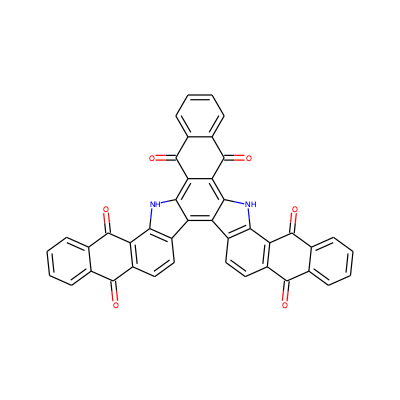

In [235]:
Draw.MolToImage(refmol, size=(400, 400))

We plot the fingerprint setting 1

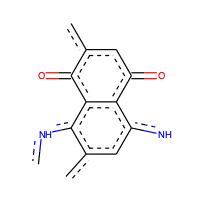

In [278]:
Draw.MolToImage(fp, size=(200, 200), kekulize=False)

Another convenient way is to highlight the fingerprint using `DrawMorganBit`. The following the same fingerprint setting, but just drawn differently.

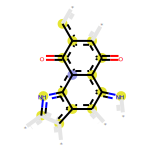

In [279]:
display(SVG(Draw.DrawMorganBit(refmol, 290, info_dicts[0], whichExample=0)))

And now let's try to plot the environment and see how that's different to the morgan bit.

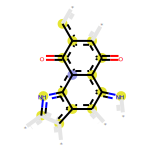

In [286]:
display(SVG(Draw.DrawMorganEnv(refmol, 29, 3)))

It turns out to be the same thing as the bit itself. 

And then fingerprint setting 2, which should look identical to 1, and expect both to be substructures of the original molecule.

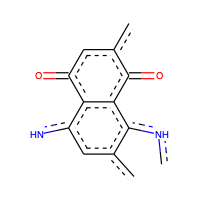

In [244]:
Draw.MolToImage(fp2, size=(200, 200), kekulize=False)

Literally the same fingerprint setting just rotated, I don't know how this is referred to in chemical terms.

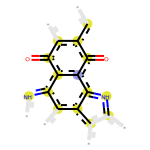

In [280]:
display(SVG(Draw.DrawMorganBit(refmol, 290, info_dicts[0], whichExample=1)))

Again how the environment is no different to the fingerprints.

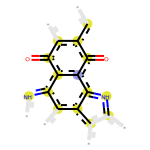

In [285]:
display(SVG(Draw.DrawMorganEnv(refmol, 18, 3)))

Now let's try to convey similarity between these two structures.

In [294]:
%%pixie_debugger

# fig, maxweight = SimilarityMaps.GetSimilarityMapForFingerprint(refmol, fp, SimilarityMaps.GetMorganFingerprint)
fig, maxweight = SimilarityMaps.GetSimilarityMapForFingerprint(fp, refmol, lambda m, idx: SimilarityMaps.GetMorganFingerprint(m, atomId=idx, radius=3, fpType='count', nBits=2048),
                                                               metric=DataStructs.TanimotoSimilarity)

In [304]:
weights = SimilarityMaps.GetAtomicWeightsForFingerprint(fp, refmol)
fig = SimilarityMaps.GetSimilarityMapFromWeights(refmol, weights)

TypeError: GetAtomicWeightsForFingerprint() missing 1 required positional argument: 'fpFunction'

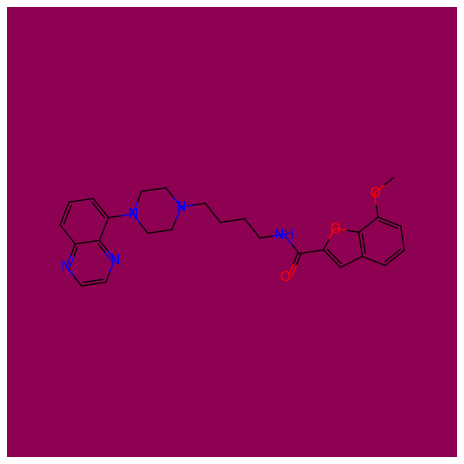

In [310]:
mol = Chem.MolFromSmiles('COc1cccc2cc(C(=O)NCCCCN3CCN(c4cccc5nccnc54)CC3)oc21')
AllChem.ComputeGasteigerCharges(mol)
contribs = [float(mol.GetAtomWithIdx(i).GetProp('_GasteigerCharge')) for i in range(mol.GetNumAtoms())]
fig = SimilarityMaps.GetSimilarityMapFromWeights(mol, attributions[0], contourLines=10)

In [316]:
AllChem.ComputeGasteigerCharges(refmol)
contribs = [float(refmol.GetSubstructMatch()).GetProp('_GasteigerCharge')) for i in range(mol.GetNumAtoms())]

IndexError: tuple index out of range

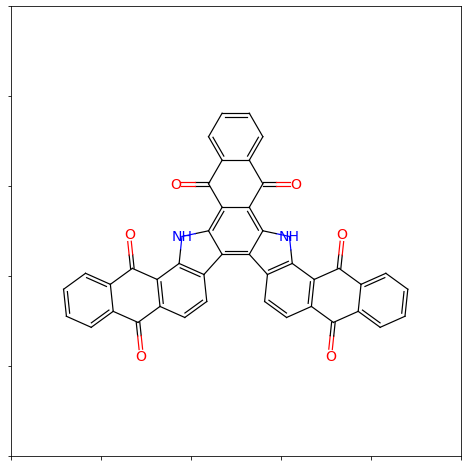

In [321]:
contribs = refmol.GetSubstructMatch(fp)
fig = SimilarityMaps.GetSimilarityMapFromWeights(refmol, contribs, colorMap='jet', contourLines=10)

/Users/kareem/miniconda3/envs/molecules_and_ml/lib/python3.6/site-packages/rdkit/Chem/Draw/SimilarityMaps.py:172: UserWarning: No contour levels were found within the data range.
  contourset = fig.axes[0].contour(x, y, z, contourLines, colors=colors, alpha=alpha, **kwargs)


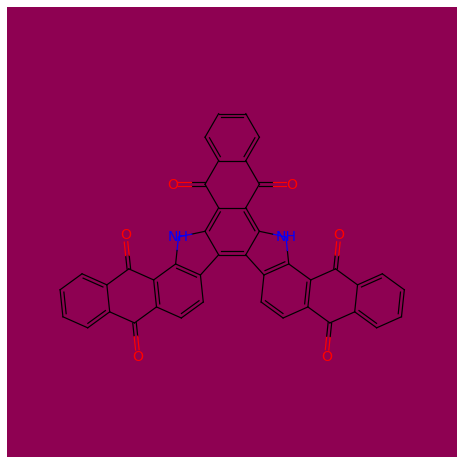

In [324]:
fig = SimilarityMaps.GetSimilarityMapFromWeights(refmol, attributions[0])

In [325]:
SimilarityMaps.GetMorganFingerprint(refmol, 18, 3)

In [331]:
help(SimilarityMaps.GetSimilarityMapForFingerprint)

Help on function GetSimilarityMapForFingerprint in module rdkit.Chem.Draw.SimilarityMaps:

GetSimilarityMapForFingerprint(refMol, probeMol, fpFunction, metric=<Boost.Python.function object at 0x7ff83ccdebc0>, **kwargs)
    Generates the similarity map for a given reference and probe molecule,
    fingerprint function and similarity metric.
    
    Parameters:
      refMol -- the reference molecule
      probeMol -- the probe molecule
      fpFunction -- the fingerprint function
      metric -- the similarity metric.
      kwargs -- additional arguments for drawing

